## **Importing libraries**

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np 
import tensorflow as tf
from tensorflow import keras
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab.patches import cv2_imshow

In [110]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

In [188]:
import imutils

# **Q1**

In [4]:
#getting the path of training  and test images from the google drive.
Training_Tissue = "/content/drive/MyDrive/EE610/A4/MoNuSeg-Training-Data/Tissue-Images"
Training_mask = "/content/drive/MyDrive/EE610/A4/MoNuSeg-Training-Data/Binary-Mask"
Test_Tissue = "/content/drive/MyDrive/EE610/A4/MoNuSeg-Test-Data/Tissue-Images"
Test_mask = "/content/drive/MyDrive/EE610/A4/MoNuSeg-Test-Data/Binary-Mask"

In [5]:
#accessing the images from the folder in drive, and making a list of it.        ref: https://pynative.com/python-glob/
training_tissue = [cv2.imread(image) for image in glob.glob(f'{Training_Tissue}/*')]
training_mask = [cv2.imread(image) for image in glob.glob(f'{Training_mask}/*')]
testing_tissue = [cv2.imread(image) for image in glob.glob(f'{Test_Tissue}/*')]
testing_mask = [cv2.imread(image) for image in glob.glob(f'{Test_mask}/*')]

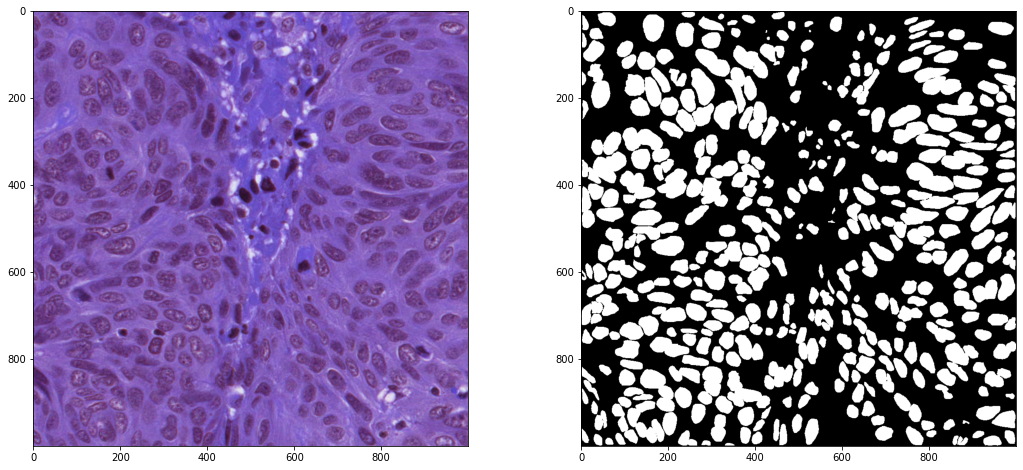

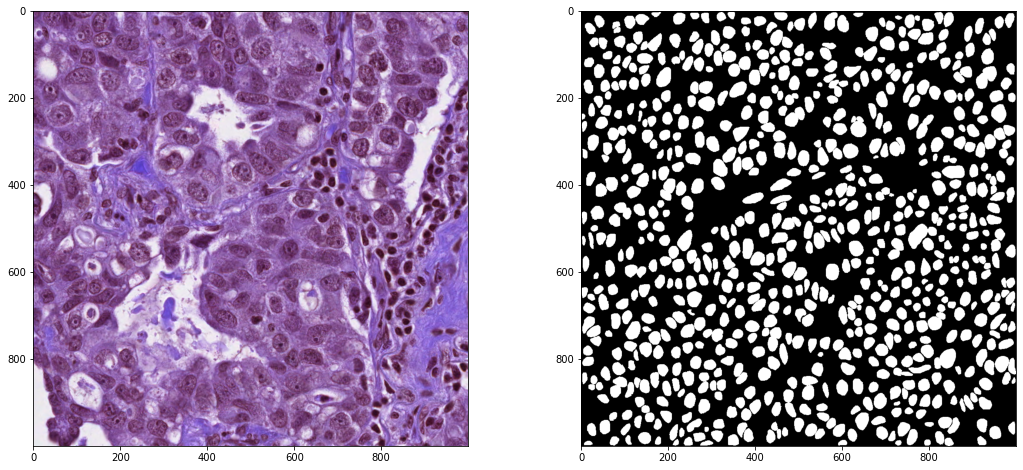

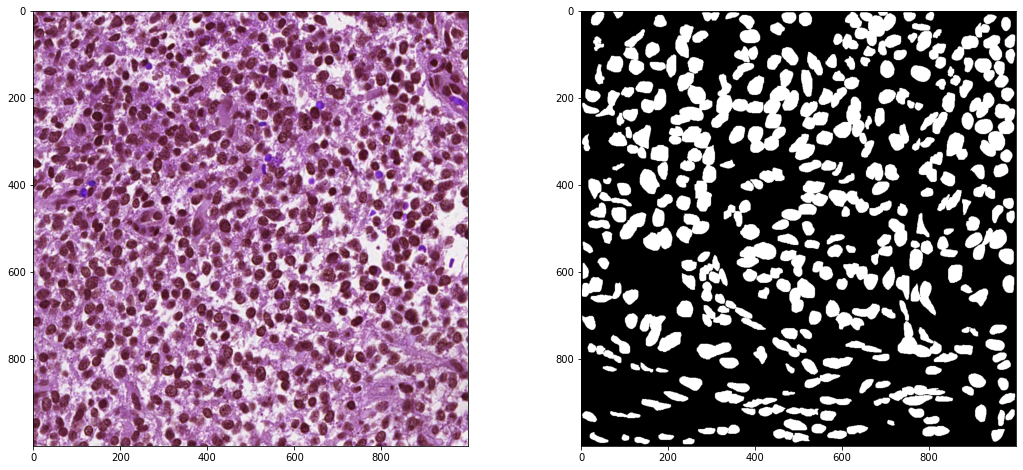

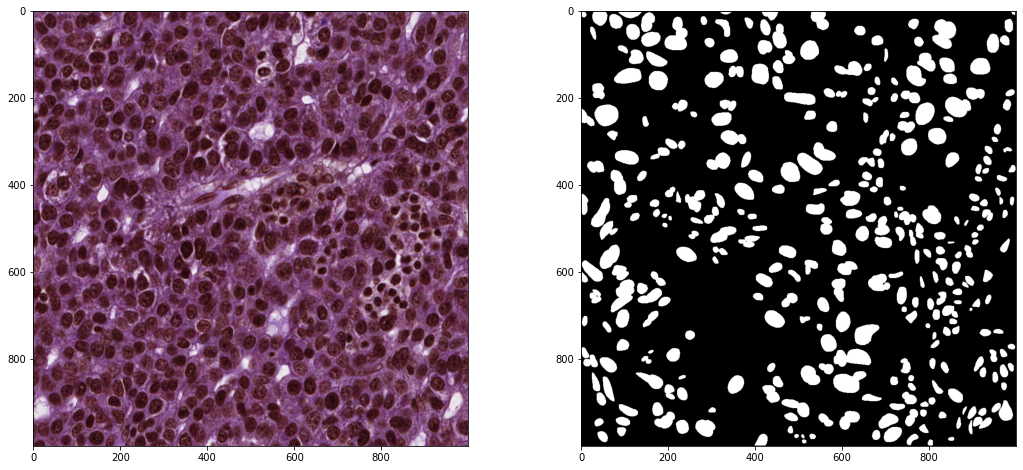

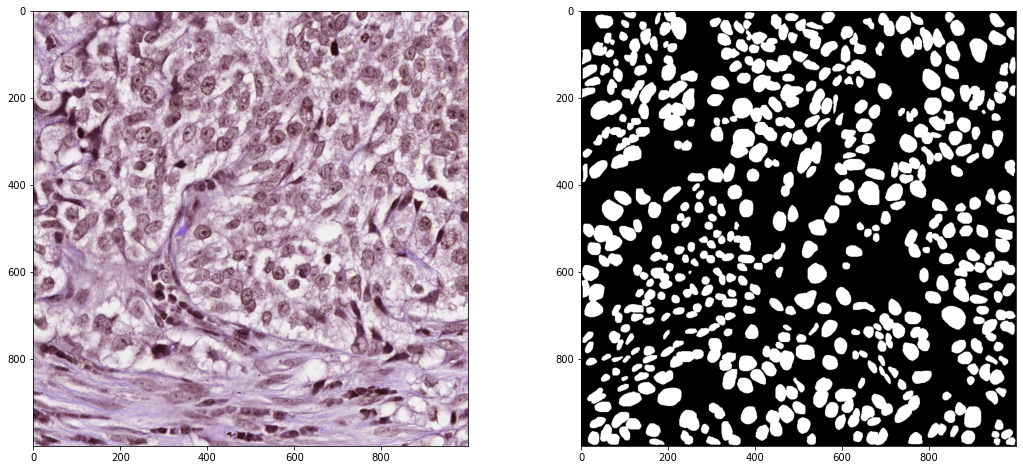

In [6]:
#showing few of the training images
for i in range(5):
   plt.figure(figsize=(18,8))
   plt.subplot(1,2,1)
   plt.imshow(training_tissue[i])
   plt.subplot(1,2,2)
   plt.imshow(training_mask[i])
   plt.show()
  # OpenCV represents RGB images as multi-dimensional NumPy arrays…but in reverse order of BGR, thus need to convert to RGB to show with matlplotlib

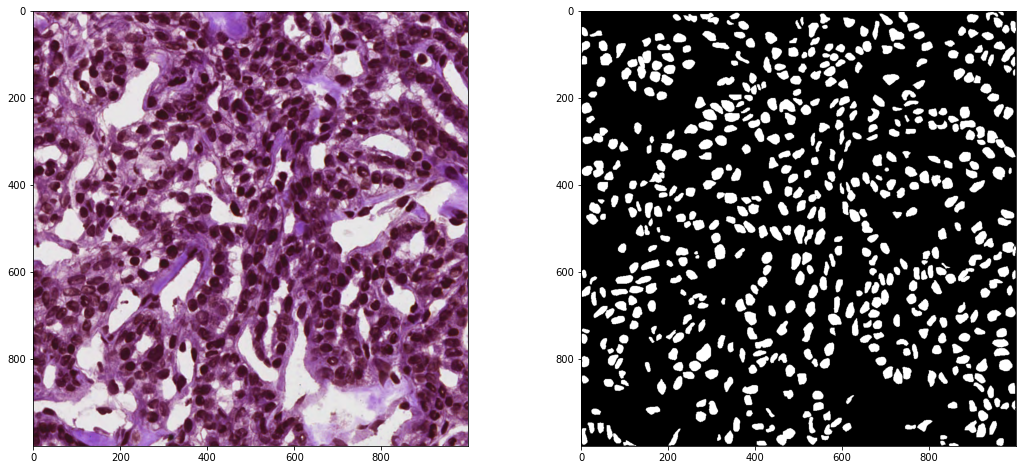

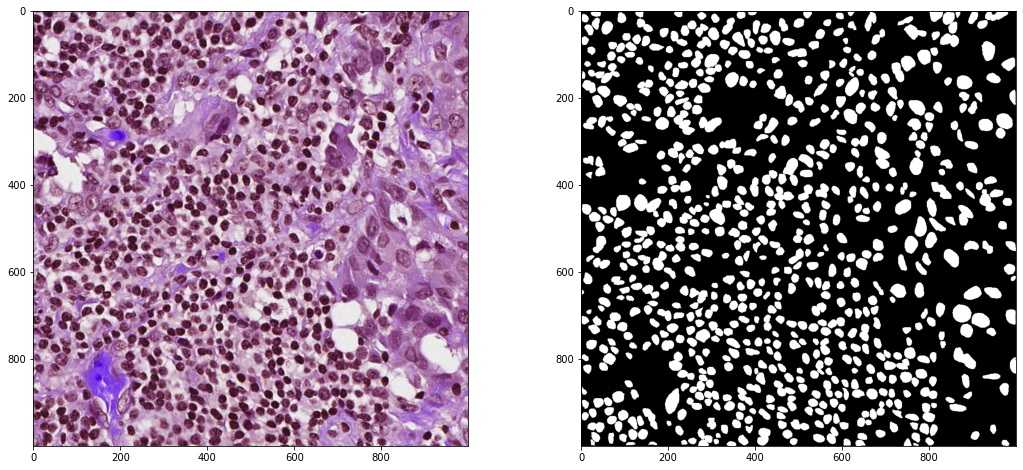

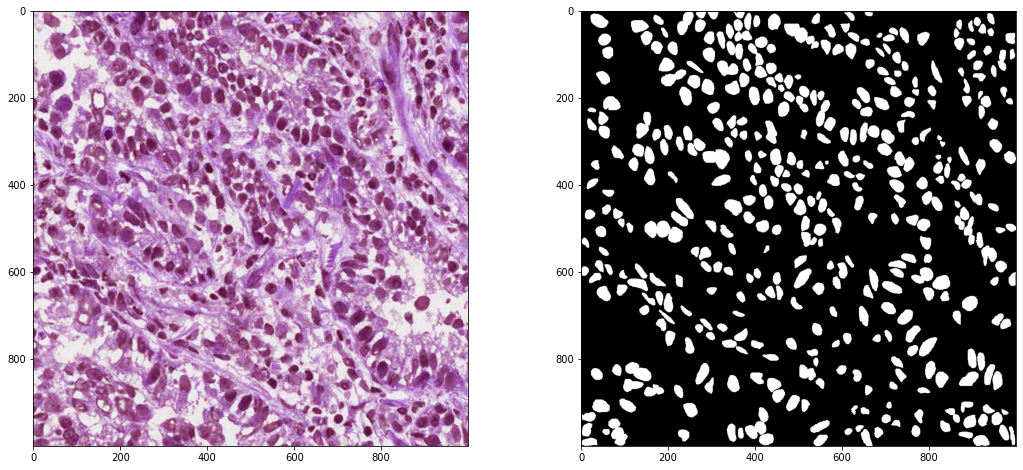

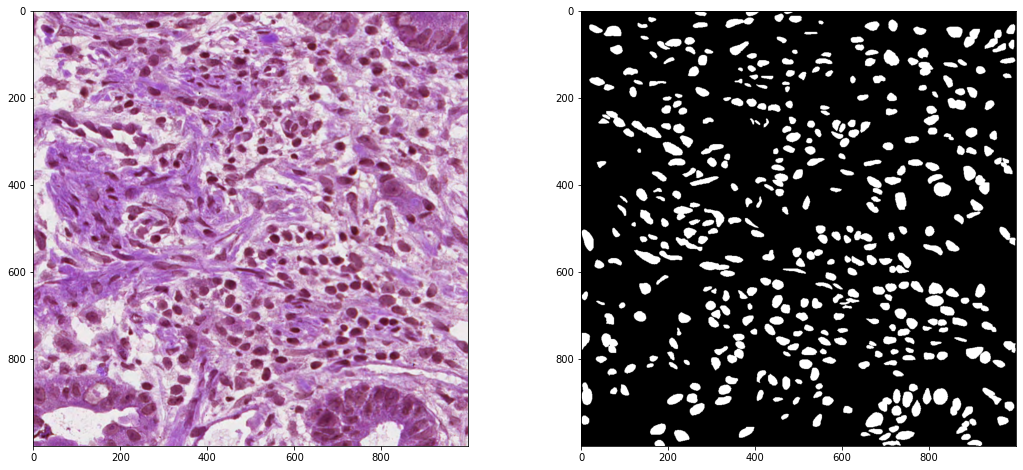

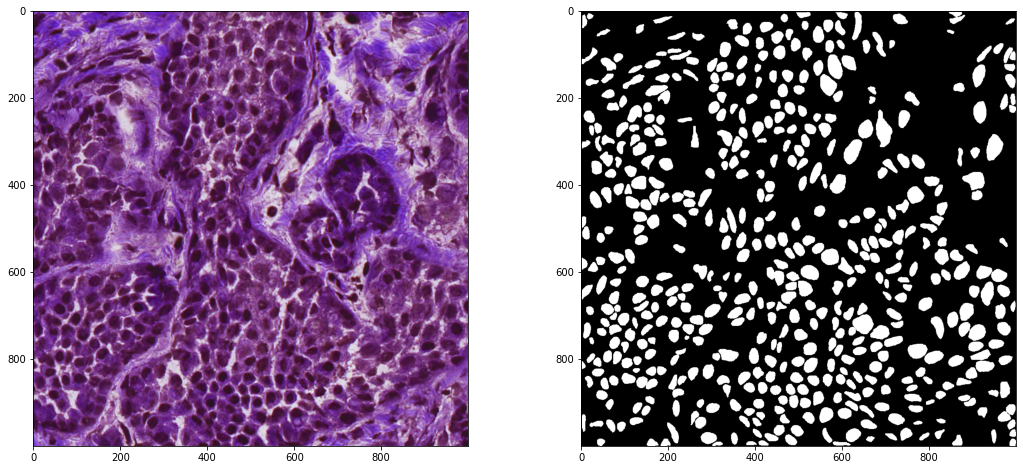

In [7]:
#showing few of the test images
for i in range(5):
   plt.figure(figsize=(18,8))
   plt.subplot(1,2,1)
   plt.imshow(testing_tissue[i])
   plt.subplot(1,2,2)
   plt.imshow(testing_mask[i])
   plt.show()

# **Q2**

# **Data Exploration**

In [8]:
testing_mask[3].shape

(1000, 1000, 3)

In [9]:
len(training_tissue)

30

In [10]:
len(training_mask)

30

In [11]:
len(testing_tissue)

14

In [12]:
len(testing_mask)

14

In [13]:
training_tissue = np.array(training_tissue)
training_mask = np.array(training_mask)
testing_tissue = np.array(testing_tissue)
testing_mask = np.array(testing_mask)

In [14]:
train_tissue = []
test_tissue = []
train_mask = []
test_mask = []

In [15]:
image_size = 512 #resizing all the images
for i in range(training_tissue.shape[0]):
  gray_tissue = cv2.cvtColor(training_tissue[i], cv2.COLOR_BGR2GRAY)
  train_tissue.append(cv2.resize(gray_tissue, (image_size, image_size)))
  train_tissue[i] = train_tissue[i]/255
  gray_mask = cv2.cvtColor(training_mask[i], cv2.COLOR_BGR2GRAY)
  train_mask.append(cv2.resize(gray_mask, (image_size, image_size)))
  train_mask[i] = train_mask[i]/255

for i in range(testing_tissue.shape[0]):
  gray_tissue = cv2.cvtColor(testing_tissue[i], cv2.COLOR_BGR2GRAY)
  test_tissue.append(cv2.resize(gray_tissue, (image_size, image_size)))
  test_tissue[i] = test_tissue[i]/255
  gray_mask = cv2.cvtColor(testing_mask[i], cv2.COLOR_BGR2GRAY)
  test_mask.append(cv2.resize(gray_mask, (image_size, image_size)))
  test_mask[i] = test_mask[i]/255


In [16]:
# splitting training set into validation set and training set in 20:80 ratio (6:24)
valid_tissue = train_tissue[24:]
train_tissue = train_tissue[:24]
valid_mask = train_mask[24:]
train_mask = train_mask[:24] 

In [17]:
train_tissue = np.array(train_tissue)
valid_tissue = np.array(valid_tissue)
test_tissue = np.array(test_tissue)

train_mask = np.array(train_mask)
valid_mask = np.array(valid_mask)
test_mask = np.array(test_mask)

In [18]:
train_tissue = np.expand_dims(train_tissue, axis=-1)
valid_tissue = np.expand_dims(valid_tissue, axis=-1)
test_tissue = np.expand_dims(test_tissue, axis=-1)

In [19]:
train_mask = np.expand_dims(train_mask, axis=-1)
valid_mask = np.expand_dims(valid_mask, axis=-1)
test_mask = np.expand_dims(test_mask, axis=-1)

In [20]:
def down_block(img, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(img)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(c)
    return c, p

def up_block(img, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D(size=(2, 2))(img)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(img, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(img)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [112]:
def UNet():
    # f = [8, 16, 32, 64, 128, 256, 512] #filter-size
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input(shape=(image_size, image_size, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #512x512 -> 256x256
    c2, p2 = down_block(p1, f[1]) #256x256 -> 128x128
    c3, p3 = down_block(p2, f[2]) #128x128 -> 64x64
    c4, p4 = down_block(p3, f[3]) #64x64 -> 32x32
    # c5, p5 = down_block(p4, f[4]) #32x32 -> 16x16
    # c6, p6 = down_block(p5, f[5]) #16x16 -> 8x8
    
    # bn = bottleneck(p6, f[6])
    bn = bottleneck(p4, f[4])
    
    # u1 = up_block(bn, c6, f[5])  #8x8 -> 16x16 
    # u2 = up_block(u1, c5, f[4])  #16x16 -> 32x32
    # u3 = up_block(u2, c4, f[3])  #32x32 -> 64x64 
    u3 = up_block(bn, c4, f[3])  #32x32 -> 64x64 
    u4 = up_block(u3, c3, f[2])  #64x64 -> 128x128 
    u5 = up_block(u4, c2, f[1])  #128x128 -> 256x256 
    u6 = up_block(u5, c1, f[0])  #256x256 -> 512x512 
    outputs = keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding="same", activation="sigmoid")(u6)
    model = keras.models.Model(inputs, outputs)
    return model

In [124]:
def dice_loss(y_true, y_pred):             #ref:  https://notebook.community/cshallue/models/samples/outreach/blogs/segmentation_blogpost/image_segmentation
  smooth = 1.                             #ref:  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9060239/
  y_true_f = tf.reshape(y_true, [-1])     #Flattens the array
  y_pred_f = tf.reshape(y_pred, [-1])
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f**2) + tf.reduce_sum(y_pred_f**2) + smooth)
  return score

def dice_score(y_true, y_pred):
  loss = 1 - dice_loss(y_true, y_pred)
  return loss

In [114]:
model = UNet()
model.compile(optimizer="adam", loss=dice_loss, metrics=[dice_score])
model.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_160 (Conv2D)            (None, 512, 512, 16  160         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_161 (Conv2D)            (None, 512, 512, 16  2320        ['conv2d_160[0][0]']             
                                )                                                           

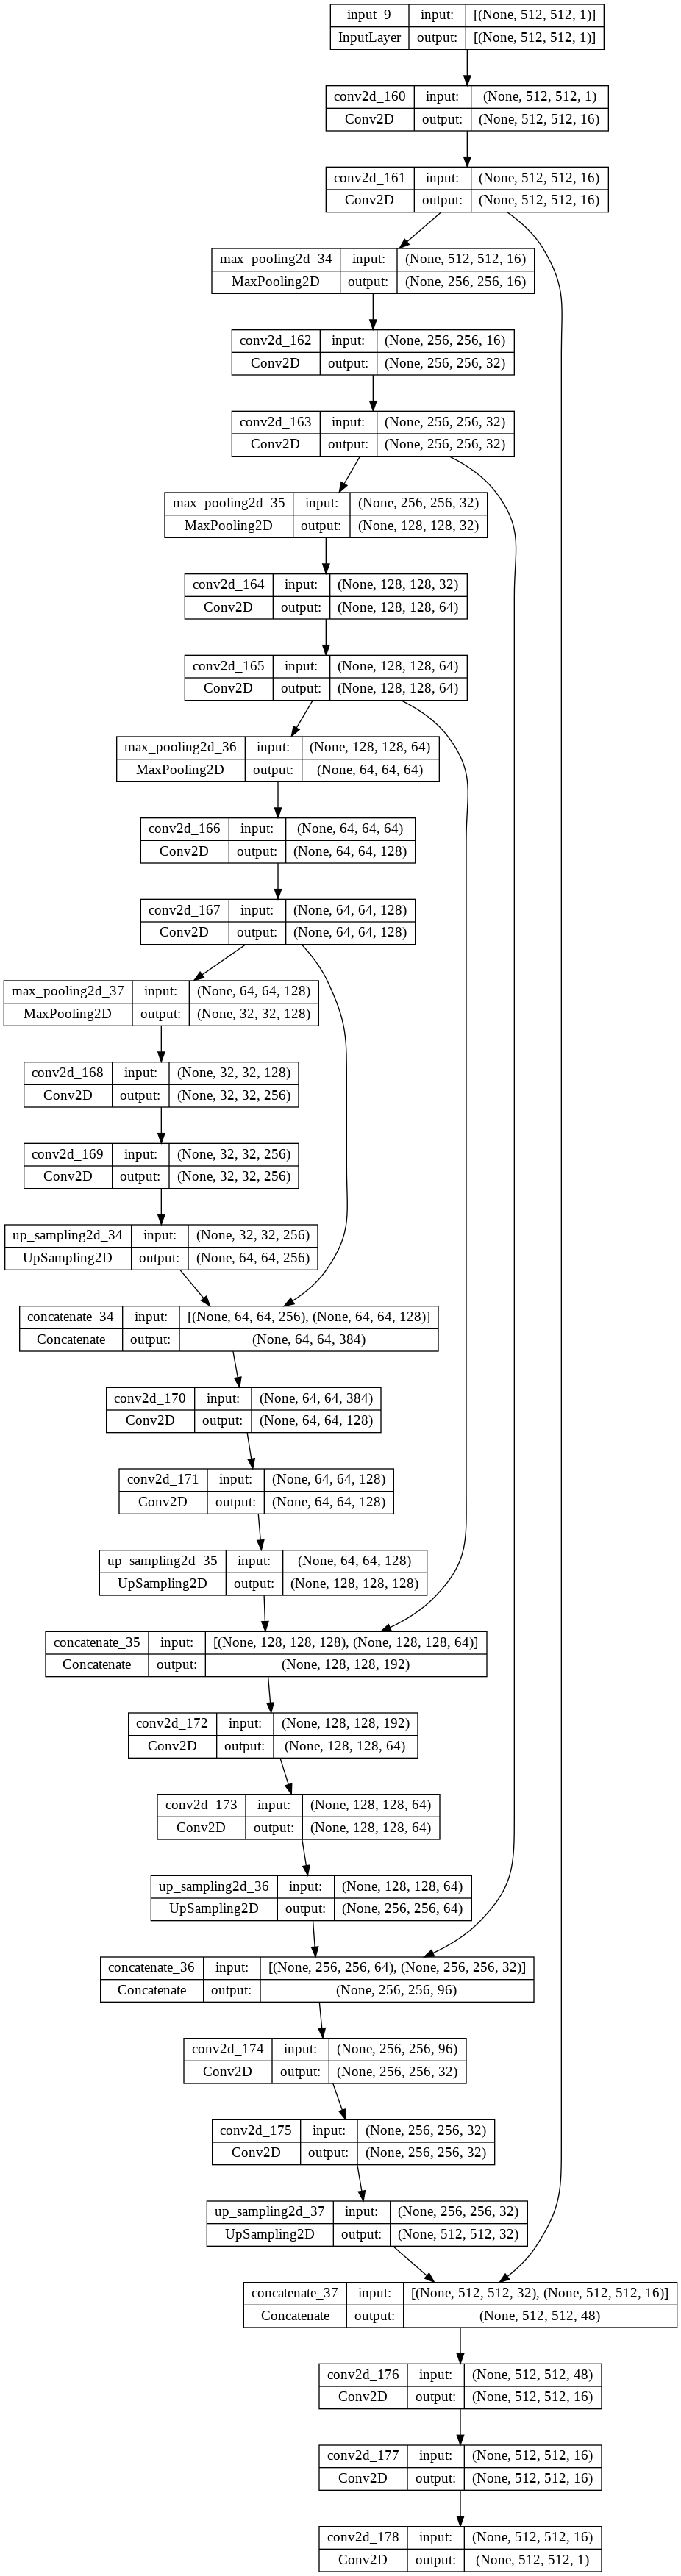

In [115]:
keras.utils.plot_model(model, show_shapes=True)

# **Q3**

In [25]:
EPOCHS = 5
BATCH_SIZE = 3

In [234]:
# train_steps = len(train_tissue)//BATCH_SIZE
# valid_steps = len(valid_tissue)//BATCH_SIZE
# model.fit(x=trng_img, y=trng_mask, batch_size= BATCH_SIZE, epochs=EPOCHS, verbose=1, steps_per_epoch=train_steps, validation_steps=valid_steps, validation_data=(valid_img, valid_mask))

In [88]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_tissue, train_mask))
# train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
# validation_dataset = tf.data.Dataset.from_tensor_slices((valid_tissue, valid_mask))

In [125]:
model.fit(x=train_tissue, y=train_mask, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(valid_tissue, valid_mask))

Epoch 1/5
8/8 [==============================] - 1s 134ms/step - loss: 0.4801 - dice_score: 0.5199 - val_loss: 0.4832 - val_dice_score: 0.5168
Epoch 2/5
8/8 [==============================] - 1s 129ms/step - loss: 0.4831 - dice_score: 0.5169 - val_loss: 0.4831 - val_dice_score: 0.5169
Epoch 3/5
8/8 [==============================] - 1s 140ms/step - loss: 0.4797 - dice_score: 0.5203 - val_loss: 0.4830 - val_dice_score: 0.5170
Epoch 4/5
8/8 [==============================] - 1s 130ms/step - loss: 0.4829 - dice_score: 0.5171 - val_loss: 0.4829 - val_dice_score: 0.5171
Epoch 5/5
8/8 [==============================] - 1s 140ms/step - loss: 0.4810 - dice_score: 0.5190 - val_loss: 0.4829 - val_dice_score: 0.5171


# **Q4**

In [126]:
pred = model.predict(x=test_tissue)

1/1 [==============================] - 0s 34ms/step


In [127]:
pred = np.squeeze(pred, axis=-1)                                #getting rid of third dimension (1)

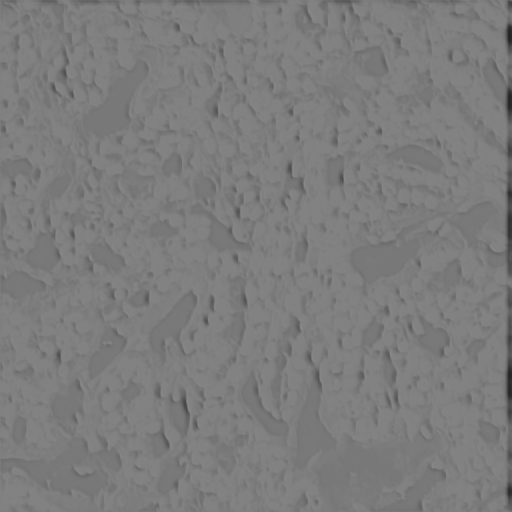

In [128]:
cv2_imshow(pred[0]*255)                                         #255 because values would be in [0,1] due to sigmoid

Some patterns are visible which can be better observed on thresholding

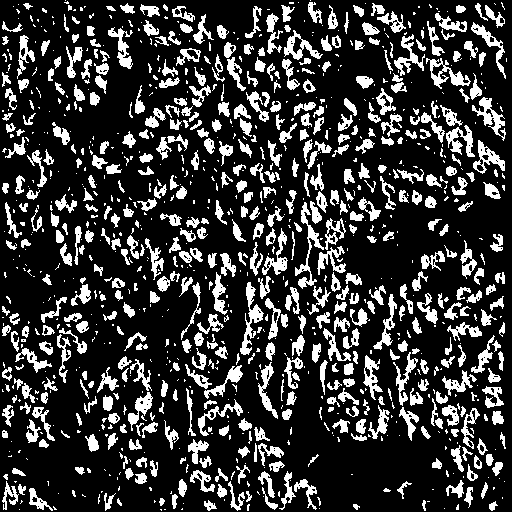

In [135]:
bw0 = pred[0].copy()
t = pred[0].mean()
for i in range(pred[0].shape[0]):
  for j in range(pred[0].shape[1]):
    if(pred[0][i][j] >= t+0.02):                       #using threshold of mean+0.02
      bw0[i][j] = 1.
    else:
      bw0[i][j] = 0.
cv2_imshow(bw0*255)

This is the prediction

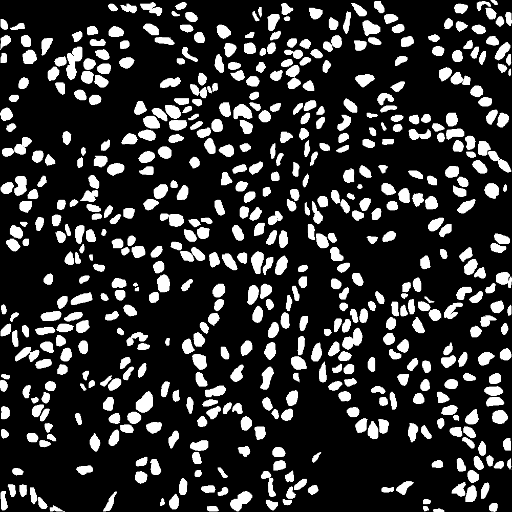

In [49]:
cv2_imshow(test_mask[0]*255)

This is ground truth

In [136]:
model.evaluate(x=test_tissue, y=test_mask)

1/1 [==============================] - 0s 241ms/step - loss: 0.5342 - dice_score: 0.4658


[0.5342312455177307, 0.4657687544822693]

# **Q5**

## **a**

Increasing no. of blocks further causes overfitting

Initially, we used 6 block layers in our model but had to reduce them to tackle overfitting. Hence few layers can be seen commented in our code while defining model.

## **b**

Increasing no. of filters also increases performance and after certain point causes overfitting

## **c**

In [179]:
def dice_ms_ssim(y_true, y_pred, t=1):
  if(len(y_true.shape)==3):
    y_true_f = y_true.copy()
  else:
    y_true_f = tf.expand_dims(y_true, axis=-1)
  if(len(y_pred.shape)==3):
    y_pred_f = y_pred.copy()
  else:
    y_pred_f = tf.expand_dims(y_pred, axis=-1)
  ms_ssim = tf.image.ssim_multiscale(y_true_f, y_pred_f, 1, filter_size=1)       #https://www.tensorflow.org/api_docs/python/tf/image/ssim_multiscale
  dice = dice_loss(y_true, y_pred)
  return t*dice + (1-t)*ms_ssim

def dice_ms_ssim_score(y_true, y_pred, t=1):
  return 1 - dice_ms_ssim(y_true, y_pred, t)

In [80]:
# tf.image.ssim_multiscale(np.expand_dims(bw, axis=-1), test_mask[0].astype(np.float32), 1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.64515525>

In [180]:
model = UNet()
model.compile(optimizer="adam", loss=dice_ms_ssim, metrics=[dice_ms_ssim_score])

In [181]:
model.fit(x=train_tissue, y=train_mask, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(valid_tissue, valid_mask))

Epoch 1/5
8/8 [==============================] - 10s 439ms/step - loss: 0.5172 - dice_ms_ssim_score: 0.4828 - val_loss: 0.5058 - val_dice_ms_ssim_score: 0.4942
Epoch 2/5
8/8 [==============================] - 1s 136ms/step - loss: 0.4388 - dice_ms_ssim_score: 0.5612 - val_loss: 0.4160 - val_dice_ms_ssim_score: 0.5840
Epoch 3/5
8/8 [==============================] - 1s 135ms/step - loss: 0.4185 - dice_ms_ssim_score: 0.5815 - val_loss: 0.4160 - val_dice_ms_ssim_score: 0.5840
Epoch 4/5
8/8 [==============================] - 1s 135ms/step - loss: 0.4192 - dice_ms_ssim_score: 0.5808 - val_loss: 0.4160 - val_dice_ms_ssim_score: 0.5840
Epoch 5/5
8/8 [==============================] - 1s 141ms/step - loss: 0.4189 - dice_ms_ssim_score: 0.5811 - val_loss: 0.4160 - val_dice_ms_ssim_score: 0.5840


In [182]:
pred = model.predict(x=test_tissue)

1/1 [==============================] - 0s 176ms/step


In [183]:
pred = np.squeeze(pred, axis=-1)                                #getting rid of third dimension (1)

In [ ]:
cv2_imshow(pred[0]*255)                                         #255 because values would be in [0,1] due to sigmoid

In [ ]:
bw1 = pred[0].copy()
t = pred[0].mean()
for i in range(pred[0].shape[0]):
  for j in range(pred[0].shape[1]):
    if(pred[0][i][j] >= t+0.00001):                       #using threshold of mean+0.001
      bw1[i][j] = 1.
    else:
      bw1[i][j] = 0.
cv2_imshow(bw1*255)

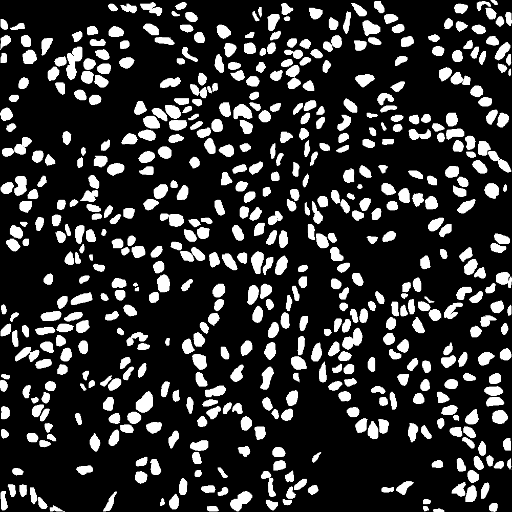

In [108]:
cv2_imshow(test_mask[0]*255)

In [185]:
model.evaluate(x=test_tissue, y=test_mask)

1/1 [==============================] - 2s 2s/step - loss: 0.3317 - dice_ms_ssim_score: 0.6683


[0.33173298835754395, 0.6682669520378113]

# **Q6**

In [187]:
# compute the exact Euclidean distance from every binary    
# pixel to the nearest zero pixel, then find peaks in this
# distance map
bw0int = bw0.astype(np.int64)
D = ndimage.distance_transform_edt(bw0int)                          #ref: https://pyimagesearch.com/2015/11/02/watershed-opencv/
localMax = peak_local_max(D, indices=False, min_distance=20,
	labels=bw0int)
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=bw0int)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

[INFO] 151 unique segments found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  import sys
/usr/local/lib/python3.7/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


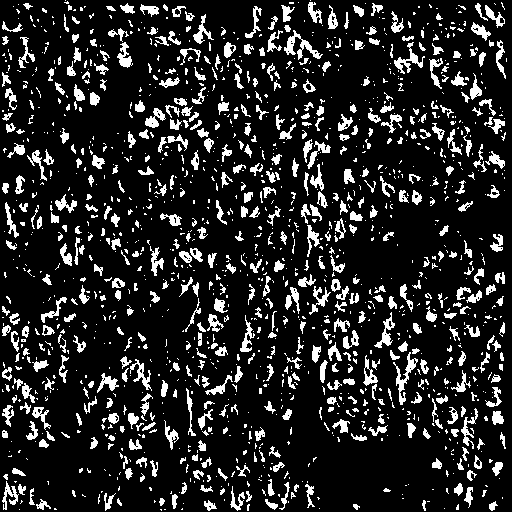

In [198]:
# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):                                             #ref: https://pyimagesearch.com/2015/11/02/watershed-opencv/
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue
	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(bw0int.shape, dtype="uint8")
	mask[labels == label] = 255
	# detect contours in the mask and grab the largest one
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)
	# draw a circle enclosing the object
	((x, y), r) = cv2.minEnclosingCircle(c)
	# cv2.circle(test_tissue[0]*255, (int(x), int(y)), int(r), (0, 255, 0), 2)
	# cv2.putText(test_tissue[0]*255, "#{}".format(label), (int(x) - 10, int(y)),
		# cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
# show the output image
cv2_imshow(bw0*255)

## **References**

1.   https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
2.   https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb
3. https://notebook.community/cshallue/models/samples/outreach/blogs/segmentation_blogpost/image_segmentation
4. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9060239/
5. https://pyimagesearch.com/2015/11/02/watershed-opencv/